STAT 453: Deep Learning (Spring 2020)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.3
IPython 7.9.0

torch 1.4.0


- Runs on CPU or GPU (if available)

# Generative Adversarial Networks (GAN)AN)

A GAN with mode collapse.

## Imports

In [2]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Settings and Dataset

In [3]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 0
generator_learning_rate = 0.001
discriminator_learning_rate = 0.001
num_epochs = 100
BATCH_SIZE = 128
LATENT_DIM = 100
IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 1
for x in IMG_SHAPE:
    IMG_SIZE *= x



##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## Model

In [4]:
##########################
### MODEL
##########################

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class GAN(torch.nn.Module):

    def __init__(self):
        super(GAN, self).__init__()
        
        
        self.generator = nn.Sequential(
            nn.Linear(LATENT_DIM, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, IMG_SIZE),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, padding=1, kernel_size=(3, 3)),
            nn.LeakyReLU(inplace=True), 
            nn.Conv2d(in_channels=8, out_channels=8, padding=1, stride=2, kernel_size=(3, 3)),
            nn.LeakyReLU(inplace=True),
            
            
            nn.Conv2d(in_channels=8, out_channels=16, padding=1, kernel_size=(3, 3)),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=16, padding=1, stride=2, kernel_size=(3, 3)),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(in_channels=16, out_channels=32, padding=1, kernel_size=(3, 3)),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, padding=1, stride=2, kernel_size=(3, 3)),
            nn.LeakyReLU(inplace=True),
            
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Linear(32, 16),
            nn.LeakyReLU(inplace=True),
            
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = model.discriminator(img)
        return pred.view(-1)




In [5]:
torch.manual_seed(random_seed)

#del model
model = GAN()
model = model.to(device)

print(model)

GAN(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Dropout(p=0.5)
    (3): Linear(in_features=128, out_features=784, bias=True)
    (4): Tanh()
  )
  (discriminator): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01, inplace)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01, inplace)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01, inplace)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): LeakyReLU(negative_

In [6]:
################################
## FOR DEBUGGING
"""
outputs= []
def hook(module, input, output):
    outputs.append(output)

for i, layer in enumerate(model.discriminator):
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        model.discriminator[i].register_forward_hook(hook)
"""

'\noutputs= []\ndef hook(module, input, output):\n    outputs.append(output)\n\nfor i, layer in enumerate(model.discriminator):\n    if isinstance(layer, torch.nn.modules.conv.Conv2d):\n        model.discriminator[i].register_forward_hook(hook)\n'

In [7]:
optim_gener = torch.optim.Adam(model.generator.parameters(), lr=generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate)

## Training

In [8]:
start_time = time.time()    

discr_costs = []
gener_costs = []
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        
        # Normalize images to [-1, 1] range
        features = (features - 0.5)*2.
        features = features.view(-1, IMG_SIZE).to(device) 

        targets = targets.to(device)

        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)
        

        ### FORWARD AND BACK PROP
        
        
        # --------------------------
        # Train Generator
        # --------------------------
        
        # Make new images
        z = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
        generated_features = model.generator_forward(z)
        
        # Loss for fooling the discriminator
        discr_pred = model.discriminator_forward(generated_features.view(targets.size(0), 1, 28, 28))
        
        gener_loss = F.binary_cross_entropy(discr_pred, valid)
        
        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()
        
        # --------------------------
        # Train Discriminator
        # --------------------------        
        
        discr_pred_real = model.discriminator_forward(features.view(targets.size(0), 1, 28, 28))
        real_loss = F.binary_cross_entropy(discr_pred_real, valid)
        
        discr_pred_fake = model.discriminator_forward(generated_features.view(targets.size(0), 1, 28, 28).detach())
        fake_loss = F.binary_cross_entropy(discr_pred_fake, fake)
        
        discr_loss = 0.5*(real_loss + fake_loss)

        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()        
        
        discr_costs.append(discr_loss)
        gener_costs.append(gener_loss)
        
        
        ### LOGGING
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), gener_loss, discr_loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Batch 000/469 | Gen/Dis Loss: 0.8191/0.7002
Epoch: 001/100 | Batch 100/469 | Gen/Dis Loss: 9.8075/0.0002
Epoch: 001/100 | Batch 200/469 | Gen/Dis Loss: 9.5446/0.0000
Epoch: 001/100 | Batch 300/469 | Gen/Dis Loss: 10.0814/0.0000
Epoch: 001/100 | Batch 400/469 | Gen/Dis Loss: 9.6357/0.0003
Time elapsed: 0.13 min
Epoch: 002/100 | Batch 000/469 | Gen/Dis Loss: 20.3945/1.3500
Epoch: 002/100 | Batch 100/469 | Gen/Dis Loss: 4.4094/0.0196
Epoch: 002/100 | Batch 200/469 | Gen/Dis Loss: 3.6181/0.0336
Epoch: 002/100 | Batch 300/469 | Gen/Dis Loss: 4.3095/0.0082
Epoch: 002/100 | Batch 400/469 | Gen/Dis Loss: 5.0360/0.0157
Time elapsed: 0.26 min
Epoch: 003/100 | Batch 000/469 | Gen/Dis Loss: 6.6942/0.0101
Epoch: 003/100 | Batch 100/469 | Gen/Dis Loss: 6.1725/0.0595
Epoch: 003/100 | Batch 200/469 | Gen/Dis Loss: 6.8481/0.0023
Epoch: 003/100 | Batch 300/469 | Gen/Dis Loss: 4.2729/0.0227
Epoch: 003/100 | Batch 400/469 | Gen/Dis Loss: 5.3958/0.0133
Time elapsed: 0.40 min
Epoch: 004/100

In [9]:
### For Debugging
#for i in outputs:
#    print(i.size())

## Evaluation

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

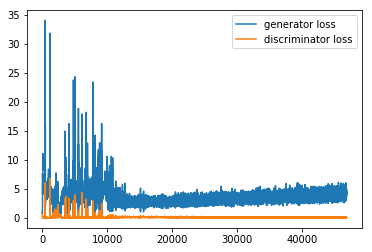

In [11]:
plt.plot(range(len(gener_costs)), gener_costs, label='generator loss')
plt.plot(range(len(discr_costs)), discr_costs, label='discriminator loss')
plt.legend()
plt.show()

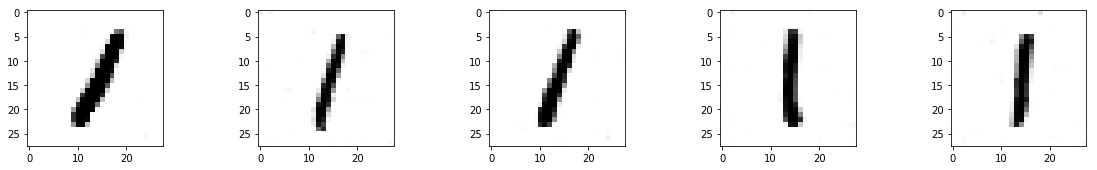

In [12]:
##########################
### VISUALIZATION
##########################


model.eval()
# Make new images
z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')

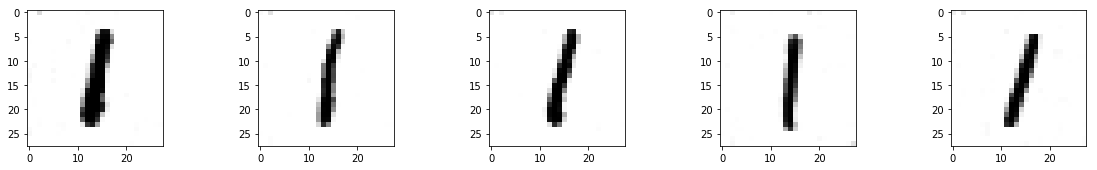

In [13]:
##########################
### VISUALIZATION
##########################


model.eval()
# Make new images
z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')

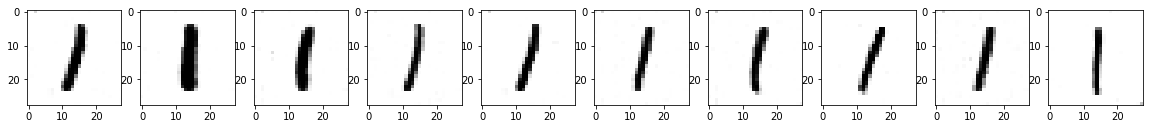

In [14]:
##########################
### VISUALIZATION
##########################


model.eval()
# Make new images
z = torch.zeros((10, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')